# 图像分割 - 一种粗暴的瀑布算法实现

In [1]:
'''
Created on Dec 25, 2018

author: cuijialiang
'''
from PIL import Image
import numpy as np
import collections, random

im_PIL = Image.open("../img/hier1.gif")
ori_im_np = np.array(im_PIL)

import matplotlib.pyplot as plt
def displayImages(images, title=None):
    fig = plt.figure(figsize=(4*len(images),3))
    for i in range(len(images)):
        a = fig.add_subplot(1,len(images),i+1)
        plt.imshow(images[i],cmap='gray')
        if title:
            a.set_title(title[i])

In [2]:
get_4neighbours = lambda i, j: [(i+1, j), (i-1, j), (i, j+1), (i, j-1)]

def split_to_groups(points):
    remain_points = set(points)
    for i, j in points:
        if (i, j) in remain_points:
            group_points = []
            queue = [(i, j)]
            remain_points.remove((i, j))
            while len(queue):
                _i, _j = queue.pop(); group_points.append((_i, _j))
                for __i, __j in get_4neighbours(_i, _j):
                    if (__i, __j) in remain_points:
                        remain_points.remove((__i, __j)); queue.append((__i, __j))
            yield group_points

def in_map(i, j, img_shape):
    if 0 <= i and i < img_shape[0]:
        if 0 <= j and j < img_shape[1]:
            return True
    return False

def get_neighbours_of_a_group(group, img_shape):
    res = []
    group_set = set(group)
    for i, j in group:
        for _i, _j in [(i+1, j), (i-1, j), (i, j+1), (i, j-1)]:
            if in_map(_i, _j, img_shape):
                if (_i, _j) not in group_set:
                    res.append((_i, _j))
    return res

def get_borders_of_a_group(group):
    group_set = set(group)
    for i, j in group:
        is_border = False
        for _i, _j in [(i+1, j), (i-1, j), (i, j+1), (i, j-1)]:
            if (_i, _j) not in group_set:
                is_border = True; break
        if is_border:
            yield i, j

def get_gradient_map(src_img):
    _g1, _g2 = np.gradient(np.array(src_img, dtype=np.float))
    return np.array(np.sqrt(_g1*_g1+_g2*_g2))

def get_level_sorted_points_on_map(gradient_map):
    gradient_points_dict = collections.defaultdict(list)
    for i in range(gradient_map.shape[0]):
        for j in range(gradient_map.shape[1]):
            gradient_points_dict[gradient_map[i, j]].append((i, j))
    levels = list(gradient_points_dict.keys())
    levels.sort()
    for level in levels:
        yield gradient_points_dict[level]

In [3]:
def seg(src_img):
    border_map, ave_map = np.array(ori_im_np), np.array(src_img)
    gradient_map = get_gradient_map(src_img)
    
    def get_level_sorted_points_in_pointslist(points):
        points_with_level = []
        for _i, _j in points:
            points_with_level.append((-gradient_map[_i, _j], _i, _j))
        points_with_level.sort()
        for _, _i, _j in points_with_level:
            yield _i, _j
    region_map, region_index, region_points = np.zeros(shape=gradient_map.shape, dtype=int), 1, collections.defaultdict(list)
    has_water = lambda _i, _j : region_map[_i, _j] > 0
    def fill_water(group, val):
        for i, j in group:
            region_map[i, j] = val
            region_points[val].append((i,j))

    for points_on_same_level in get_level_sorted_points_on_map(gradient_map):
        for group in split_to_groups(points_on_same_level):
            group_neighbours = get_neighbours_of_a_group(group, src_img.shape)
            filled = False
            for neighbour_i, neighbour_j in get_level_sorted_points_in_pointslist(group_neighbours):
                if has_water(neighbour_i, neighbour_j):
                    fill_water(group, region_map[neighbour_i, neighbour_j])
                    filled = True
                    break
            if not filled:
                fill_water(group, region_index)
                region_index += 1
    
    for region in region_points.values():
        for i, j in get_borders_of_a_group(region):
            border_map[i, j] = 0
        sum_grayscale = 0.
        for i, j in region:
            sum_grayscale += ori_im_np[i, j]
        ave_grayscale = int(sum_grayscale / len(region))
        for i, j in region:
            ave_map[i, j] = ave_grayscale
    return border_map, ave_map

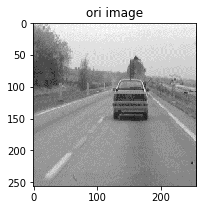

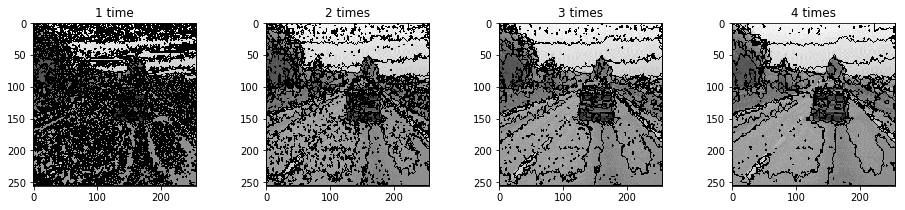

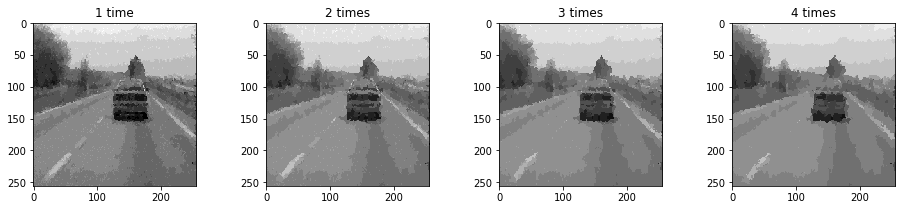

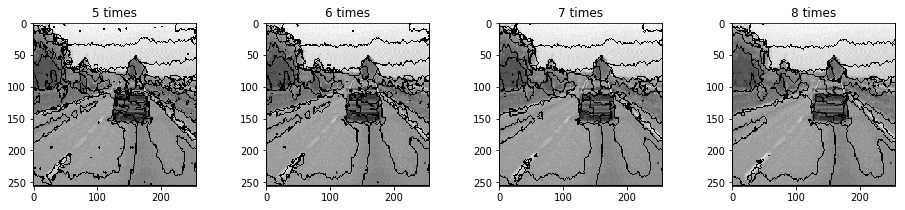

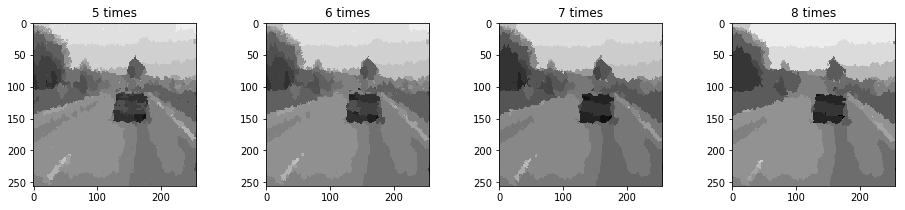

In [4]:
src_img = ori_im_np
border_maps, ave_maps = [], []
for i in range(16):
    border_map, ave_map = seg(src_img)
    border_maps.append(border_map); ave_maps.append(ave_map)
    src_img = ave_map

displayImages([ori_im_np], ['ori image'])
titles = ['1 time', '2 times', '3 times', '4 times']
displayImages(border_maps[:4], titles)
displayImages(ave_maps[:4], titles)
titles = ['5 times', '6 times', '7 times', '8 times']
displayImages(border_maps[4:8], titles)
displayImages(ave_maps[4:8], titles)

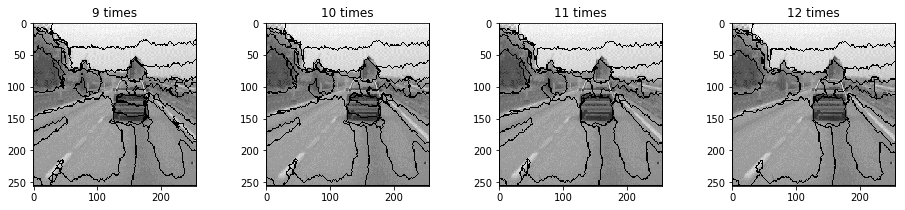

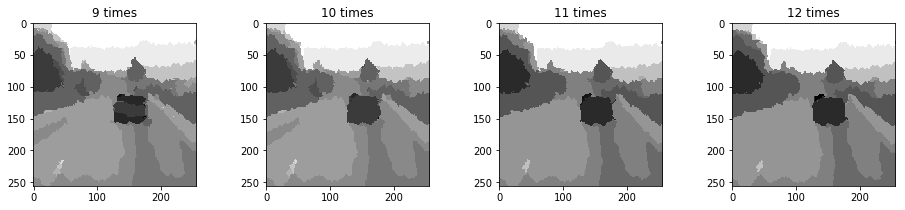

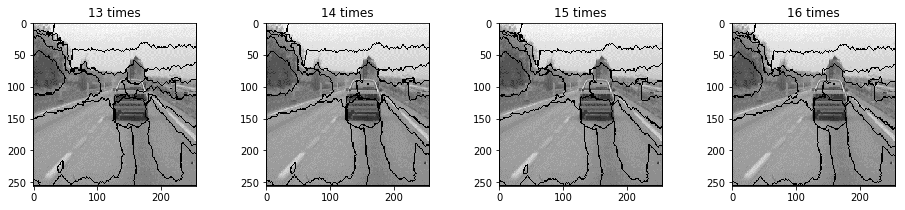

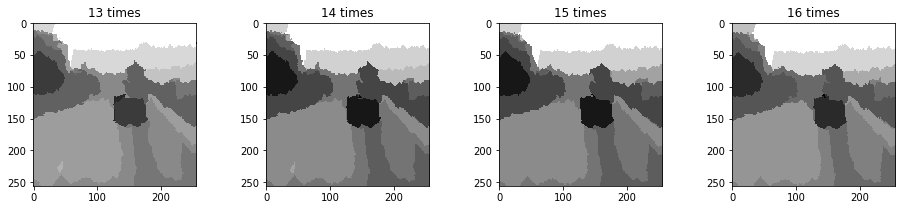

In [5]:
titles = ['9 times', '10 times', '11 times', '12 times']
displayImages(border_maps[8:12], titles)
displayImages(ave_maps[8:12], titles)
titles = ['13 times', '14 times', '15 times', '16 times']
displayImages(border_maps[12:16], titles)
displayImages(ave_maps[12:16], titles)